# Special Relativity Visualizer
By: Albert Han, Stephen He, and David Zhang

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML


# 1. Setting up the simulation:


### a). Simulation Class
For this project , we will use a Simulation Class to set up everything. The simulation class will consist of objects represnted as a collection of points. We will be able to add objects at a given speed (relative to the base frame), i.e. in a certain frame, and the simulation class will tranform everything into the ground frame. Our simulation will be based in 2D, just for simplicity. We are doing this, as opposed to 1D, so we can better simulate the paradoxes.

To Initialize the class, we will have these variables

```
objects
velocities
frameVelocity
events
eventVelos
```

`objects` Is a 3D array, each entry of the array stores an object, repesented as a 2D array, where each entry is a point that specifies points in the object. For our animation, we will just linearly interpolate and connect all the points to eachother

`velocities` is a 2D array, which has the same size as `objects`. Velocities stores the velocity of the object. But, you may be wondering, which frame are we measuring in? The velocity of this frame, relative to the ground frame, is stored in `frameVelocity`.

`events` stores space time events, which will be plotted sepearately

Finally, something to note is that we will be using natural units, where $c = 1$

In [ ]:
class Simulation():
  def __init__(self):
    self.objects = []
    self.velocieis = []
    self.frameVelocity =[]
    self.events = []
    self.eventVelos = []
    #Adding the origin to the simulation when we initinalize
    self.objects.append([[0,0,0]])
    self.velocieis.append([0,0])
    self.frameVelocity.append([0,0])

### b). Adding Objects

Now, to add some simple objects. `addObject` is a generic class that can add any object. The other functions make it easier to add specific objects, and will ensure that they will be written in the right order for our animation.

In [ ]:
class Simulation(Simulation):
  def addObject(self, ptList, velocity, frameVelo):
    self.objects.append(ptList)
    self.velocieis.append(velocity)
    self.frameVelocity.append(frameVelo)

  def addPt(self, fVec, velocity, frameVelo):
    self.objects.append([fVec])
    self.velocieis.append(velocity)
    self.frameVelocity.append(frameVelo)

  def addLine(self, startPt, L, velocity, frameVelo, doX, t):
    line = [[t,startPt[0], startPt[1]]]
    if(doX):
      line.append([t, startPt[0] + L, startPt[1]])
    if(not doX):
      line.append([t, startPt[0], startPt[1] + L])
    self.objects.append(line)
    self.velocieis.append(velocity)
    self.frameVelocity.append(frameVelo)

  def addTrain(self, bottomLeft, L, H, velocity, frameVelo, t):
    startPt = bottomLeft
    train = [[t, bottomLeft[0], bottomLeft[1]], [t, startPt[0] + L, startPt[1]], \
    [t, startPt[0] + L, startPt[1] + H], [t, startPt[0], startPt[1] + H], [t, bottomLeft[0], bottomLeft[1]]]

    self.objects.append(train)
    self.velocieis.append(velocity)
    self.frameVelocity.append(frameVelo)

  def addPerson(self, pos, velocity, frameVelo, size,t):
    h = 0.5 * size

    person = [[t,pos[0],pos[1]], [t, pos[0] + 0.5 * h, pos[1]], [t,pos[0] + 0.5 * h, pos[1] + h],\
              [t, pos[0] - 0.5 * h, pos[1]+h], [t,pos[0] - 0.5 * h, pos[1]], [t,pos[0],pos[1]],
              [t,pos[0] + 0.5 * h, pos[1] - 1.5 * h], [t,pos[0] - 0.5 * h, pos[1] - 1.5 * h]]

    self.objects.append(person)
    self.velocieis.append(velocity)
    self.frameVelocity.append(frameVelo)

  def addEvent(self,event, fVelo):
    self.events.append(event)
    self.eventVelos.append(fVelo)

  #A pulse is like a clock, where very dT seconds it adds an event
  def addPulse(self, pt, dT, Ts, Tend, frameVelo):
    range = np.linspace(Ts, Tend, dT, endpoint = True)
    for i in range:
      self.events.append([i, pt[0], pt[1]])
      self.eventVelos.append(frameVelo)

### c). Switching Frames

Now, some helper functions to help switch frame

Some notes on the functions:
`getGamma` returns the gamma value for the given velocity

`lorentzTransformPt` transforms a 4 vector from from S to frame S' where S' is traveling at V w.r.t S

'addVelocities' Returns the velocity of an object moving at `objectVelo` in Frame 1 moving at `Vf1` w.r.t the ground frame into Frame 2 moving at `Vf2` w.r.t the ground frame.
To do this, we will use lorentzTranformPt to transform the velocity 4-Vector from Frame 1 to the ground frame then to Frame 2.

`lorentzTransformObject` applys a lorenz transformation to every point in the object at a given time t and returns a new 4 vector with all the points. The main purpose of this function is to help with `getEOM`
Note: in the new frame, all the points may not be at the same time, which is why this is just a helper function.

`getEOM` will return the EOM for an object, i.e. the x and y position as a function of the proper time. It takes an object traveling at objectVelo in Frame 1 which is moving at Vf1 w.r.t the ground frame. It returns the equations of motion, in the same order (which will be linear because everything has constant velocity) as a function of the proper time in Frame 2.

The EOMs are returned in the following form: If the EOMs are $$x = at + b$$ $$y = ct + d$$
For point n, then `getEOM` will return a vector where `vec[n-1]` stores `[[a,b],[c,d]]`

In [ ]:
#Where Vf is relative to the ground grame
def getGamma(Vf):
  return (1 - Vf[0] * Vf[0] - Vf[1] * Vf[1]) ** (-0.5)



def lorentzTranformPt(fourVec, V):
  newFourVec = np.array(fourVec)
  g = getGamma(V)
  bx = V[0]
  by = V[1]
  g2 = g**2/(1 + g)
  LTMat = np.array([
      [g, -g * bx, -g * by],
      [-g * bx, 1 + g2 * bx * bx, g2 * bx * by],
      [-g * by, g2 * bx * by, 1 + g2 * by * by]
  ])
  return LTMat @ newFourVec


#Vf1, Vf2 are relative to the ground frame
#We are assuming that the object is in frame 1
#Returns the velocity of object in Vf2
def addVelocities(objectVelo, Vf1, Vf2):
  gamma = getGamma(objectVelo)
  Vvec = [gamma, gamma * objectVelo[0], gamma * objectVelo[1]]
  #Using -Vf1 since Frame 1 is moving at Vf1 wrt the ground, so the ground is
  #moving at -Vf1 wrt Frame 1
  GroundVec = lorentzTranformPt(Vvec, [-1 * Vf1[0], -1 * Vf1[1]])
  Frame2Vec = lorentzTranformPt(GroundVec, Vf2)
  return [Frame2Vec[1]/Frame2Vec[0], Frame2Vec[2]/Frame2Vec[0]]

def lorentzTransformObject(Object, V):
  newObject4Vectors = []
  for pt in Object:
    newFVec = lorentzTranformPt(pt, V)
    newObject4Vectors.append(newFVec)
  return newObject4Vectors


def getEOM(Object, objectVelo, Vf1, Vf2):

  Vf1wrtVf2 = addVelocities([0,0], Vf1, Vf2)
  #We are using Vf1wrtVf2 since we are treating every endpoint of Object1 as
  #a point in spacetime, so it has a coordinate in Frame 1, which we transform
  #to frame 2. Then, we wait a few seconds and then transform the object to
  #frame 2. This gives us two points in frame 2 we can interpolate

  #We shoudln't run into any issues with similenatity since points on the two
  #Events will be timelikely separated
  Object1 = lorentzTransformObject(Object, Vf1wrtVf2)
  dT = 1
  Object2 = []
  for pt in Object:
    newPt = [pt[0] + dT, pt[1] + dT * objectVelo[0], pt[2] + dT*objectVelo[1]]
    Object2.append(newPt)
  Object2 = lorentzTransformObject(Object2, Vf1wrtVf2)

  EOMS = []
  for i in range(len(Object1)):
    Tps = [Object1[i][0], Object2[i][0]]
    Xps = [Object1[i][1], Object2[i][1]]
    Yps = [Object1[i][2], Object2[i][2]]

    xLine = np.polyfit(np.array(Tps), np.array(Xps), 1)
    yLine = np.polyfit(np.array(Tps), np.array(Yps), 1)
    EOMS.append([xLine, yLine])
  return EOMS


Some code for testing stuff

In [ ]:
print(getGamma([0,0]))
print(addVelocities([0,0.5], [0,0], [0,-0.5])) #
print(addVelocities([0.5,0], [0,0], [-0.5,0])) #
print(addVelocities([0,0], [0,0], [-0.5,0])) #
print(addVelocities([0.7,0], [0.4,0], [0,0])) #
print(addVelocities([0.9,0], [0.9,0], [0,0])) #

1.0
[np.float64(0.0), np.float64(0.8)]
[np.float64(0.8), np.float64(0.0)]
[np.float64(0.5), np.float64(0.0)]
[np.float64(0.859375), np.float64(0.0)]
[np.float64(0.9944751381215468), np.float64(0.0)]


### d). Running the Simulation

Now, to actually run the simulation. To do this, we will make some simplifying assumptions for our model. Every object added has a constant velocity (something usually done in intro relativity). However, this is useful because this means that the velocity of every object is constant in every frame! This allows us to cacluate two points in each objects space time path, and linearly interpolate for any frame. The high level overview is as follows:



1.   The fuction, `runSimulation(frameVelocity, dT, Ts, Tend, condition)` takes the velocity of the frame, the time step, the total time, and a condition to stop at
2. Transform the coordinates and velocities of every object and event to the given frame, using the helper functions above
3.  Generate an equation for the position of the object, as a function of the proper time.
4. Get as many points as neccesary, this part will just consist of plugging everything into the equation.

Some caveats to this method are we can't have dicontinuous changes in velocity, ex, starting and stoppping. To fix this, we can splice multiple animations together (Making sure our frames are consistent).
To do this, we can stop our simulation until a condition, read out the values (in a single frame), change the velocity of and object, and start a new simulation.

`condition` will be a function that returns true or false and takes the current time. It can be specified with a lambda function before the simulation is run.
For example, if we wanted to stop when an event occured, we can find the space time coordinate of the event beforehand, then have condition return false after the event occurs.

The simulation will return an array of points for all the objects. This array will look like `objects[t][i][j][pos]`, where `t` is the time step, `i` is the object number, `j` is the number of each point in the object, and pos is $x$ or $y$. Events will also be stored in this array, and they will have a point for a small time interval (~50 frames after they occur).


In [ ]:
class Simulation(Simulation):
  def runSimulation(self, frameVelocity, dT, Ts, Tend, condition):
    newEvents  = []
    objectEOMS = []
    for i in range(len(self.events)):
      relVel = addVelocities([0,0], self.eventVelos[i], frameVelocity)
      newEvents.append(lorentzTranformPt(self.events[i], relVel))
    for i in range(len(self.objects)):
      EOM = getEOM(self.objects[i], self.velocieis[i],\
                   self.frameVelocity[i], frameVelocity)
      objectEOMS.append(EOM)

    times = []
    objects = []
    currentT = Ts
    while(currentT < Tend and condition(currentT)):
      times.append(currentT)
      timeStepObjects = []
      for EOM in objectEOMS:
        currentObject = []
        for pt in EOM:
          Xpos = pt[0][0] * currentT + pt[0][1]
          Ypos = pt[1][0] * currentT + pt[1][1]
          vec = [Xpos, Ypos]
          currentObject.append(vec)
        timeStepObjects.append(currentObject)

      for event in newEvents:
        if(np.abs(event[0] - currentT) < 10 * dT):
          timeStepObjects.append([[event[1], event[2]]])

      # times.append(currentT)
      objects.append(timeStepObjects)
      currentT = currentT + dT

    return times, objects


### e). Minkowski Diagrams

Since our simulation can have a lot of points and frames, especially with the objects and since our simulation is 2D (So the minkoski diagram is 3D), were going to make a minkowski diagram class that will plot points and two different spacetime axis.
The first frame is assumed to be at rest
To plot moving objects, we can tell it to plot multiple points.
The objects should be entered in the same format as before, a list of space time coordinates with $(t,x,y)$

Just to make the plots easier to see, the Minkowski function will only show the axis if the velocity has a positive x and y component (Since otherwise the axis get squished the other way, and plotting all 8 quadrants is hard to see)

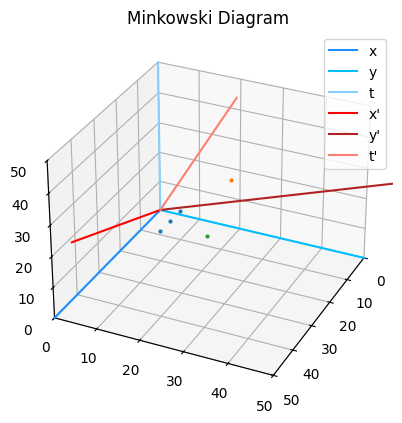

In [ ]:
def Minkowski(frame2Velo, frame1Objects, frame2Objects, Ielev=30, Iazi=45):
  vPar = frame2Velo
  vPerp = np.array([0, frame2Velo[1], -1 * frame2Velo[0]])
  vMag = (vPar[0] * vPar[0] + vPar[1] * vPar[1])** 0.5
  vUnit = np.array(vPar)/vMag

  vPerpUnit = vPerp/vMag
  vParUnit = np.array(vPar)/vMag


  newTime = np.array([1, vPar[0], vPar[1]])
  newV = np.array([vMag, vUnit[0], vUnit[1]])

  tUnit = newTime/(np.linalg.norm(newTime))
  vUnit = newV/np.array(np.linalg.norm(newV))
  Uprime =  ( (1 + vMag ** 2) /(1 - vMag**2 ) ) ** 0.5
  tUnit = Uprime * tUnit
  vUnit = Uprime * vUnit

  newX = (vParUnit[0]  * vUnit + vParUnit[1] * vPerpUnit)
  newY = (vParUnit[1] * vUnit - vParUnit[0] * vPerpUnit )
  newT = tUnit

  xAxis = []
  yAxis = []
  tAxis = []
  for i in range(50):
    xAxis.append(newX * i)
    yAxis.append(newY * i)
    tAxis.append(newT * i)
  xAxis = np.array(xAxis)
  yAxis = np.array(yAxis)
  tAxis = np.array(tAxis)

  newFrame2 = []
  for obj in frame2Objects:
    objArr = []
    for pt in obj:
      newPt = pt[0] * newT + pt[1] * newX + pt[2] * newY
      objArr.append(newPt)
    newFrame2.append(objArr)
  newFrame2 = np.array(newFrame2)


  Axis = np.linspace(0,50, 50)
  Zeros = np.zeros(50)

  #Plotting
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.set_xlim(0, 50)
  ax.set_ylim(0, 50)
  ax.set_zlim(0, 50)
  ax.plot(Axis, Zeros, Zeros, label = "x", color = "dodgerblue")
  ax.plot(Zeros, Axis, Zeros, label = "y", color = "deepskyblue")
  ax.plot(Zeros, Zeros, Axis, label = "t", color = "lightskyblue")

  ax.plot(xAxis[:,1], xAxis[:,2], xAxis[:,0], label = "x'", color = "red")
  ax.plot(yAxis[:,1], yAxis[:,2], yAxis[:,0], label = "y'" , color = "firebrick")
  ax.plot(tAxis[:,1], tAxis[:,2], tAxis[:,0], label = "t'" , color = "salmon")

  for obj in frame1Objects:
    obj = np.array(obj)
    ax.plot(obj[:,0], obj[:,1], obj[:,2], 'o', markersize = 2)

  for obj in newFrame2:
    obj = np.array(obj)
    ax.plot(obj[:,0], obj[:,1], obj[:,2], 'o', markersize = 2)


  ax.legend()




  ax.view_init(elev=Ielev, azim=Iazi)
  plt.title("Minkowski Diagram")
  plt.show()

Minkowski([0.5, 0.5] , [[[10,10,10], [15,10,10], [20,10,10]], [[5,20,20]]], [[[15,15,15]] ], 30, 25)

### f). Animation

Finally, its time to animate! Animation will take a list of simulations, all of which are outputs from runSimulation. It takes a list so we can stitch together multiple simulations to get discontinuties in the velocity.

Note: for the stitching to work properly, the objects must be in the same order in all simulations.

In [ ]:
#This animaition code is based off the chaos assignment
#plotlimits[0] - xmin, xmax, ymin, ymax
#This is so lenth contraction will properly show
def RelatavisticAnimation(simulations, plotLimits, title):
    maxObjectNum = 0
    AllSimulations = []
    for simulation in simulations:
      for timeStep in simulation:
        AllSimulations.append(timeStep)
        if(len(timeStep) > maxObjectNum):
          maxObjectNum = len(timeStep)
    fig, ax = plt.subplots()
    ax.set_xlim(plotLimits[0],plotLimits[1])
    ax.set_ylim(plotLimits[2],plotLimits[3])
    plt.title(title)
    lines=[]
    for i in range(maxObjectNum):
        line, = ax.plot([], [], '-', marker='o')
        lines.append(line)

    def update(i, AllSimulations,lines, maxObjNum):
        currentTs = AllSimulations[i]
        for j in range(maxObjNum):
          if(j < len(currentTs)):
            obj = np.array(currentTs[j])
            lines[j].set_data(obj[:,0],obj[:,1])

          else:
            lines[j].set_data([], [])

        return lines
    ll=1

    ani = animation.FuncAnimation(fig, update, len(AllSimulations), fargs=[AllSimulations, lines, maxObjectNum],
                      interval=20, blit=True,repeat=False)
    plt.close()
    return ani

In [ ]:
def trueCond(t):
  return True

In [ ]:
sim = Simulation()
sim.addLine([0,0], 5, [0,0], [-0.99,0], True, 0)
sim.addLine([0,1], 5, [0,0], [-0.5,0], True, 0)
sim.addLine([-1,0], 5, [0,0], [-0.5,0], False, 0)
times, output = sim.runSimulation([0,0.1], 0.1, 0,10,trueCond)

Heres a basic test of length contraction, **It Works!**

In [ ]:
plotLimts = [-5, 10 , -6 ,6]
ani=RelatavisticAnimation([output], plotLimts, "Testing")
HTML(ani.to_jshtml())
ani.save('test.gif',writer='pillow',fps=30)

# 2. The Fundamental Effects:

Now, its time for the classic experiments, starting with Time Dialation. For this, we won't use laser pulses (since it would be too hard to animate), instead, we'll show a relatavistic "train" (visualized with a box) with a clock which will fire a pulse at consistent intervals. (green dot)

Note the origin is the blue dot.

### a). Time dialation





In [ ]:
TDsim = Simulation()
pt = np.array([0,0])
frame_velo = np.array([0.8,0])
TDsim.addPulse(pt, 3, 5, 15,frame_velo)
TDsim.addTrain([-1,-1], 2,2,[0,0],frame_velo, 0)

TDtimes, TDout = TDsim.runSimulation(frame_velo, 0.1, 0 , 20,trueCond)

In [ ]:
plotLimts = [-20, 20, -5, 5]
ani=RelatavisticAnimation([TDout], plotLimts, "Moving Uniform Pulse in Pulse Frame")
HTML(ani.to_jshtml())
ani.save('Moving Uniform Pulse in Pulse Frame.gif',writer='pillow',fps=30)

In [ ]:
TDtimes2, TDout2 = TDsim.runSimulation([0,0], 0.1, 0 , 20,trueCond)
plotLimts = [-20, 20, -5, 5]
ani=RelatavisticAnimation([TDout2], plotLimts, "Moving Uniform Pulse in Ground Frame")
HTML(ani.to_jshtml())
ani.save('Moving Uniform Pulse in Ground Frame.gif',writer='pillow',fps=30)

Testing for a Light Moving Up and Down

In [ ]:
class Simulation(Simulation):
  def addLightBounce(self, pt,dT, Ts, Tend, frameVelo):
    # range = np.linspace(Ts, Tend, dT, endpoint = True)
    range = np.arange(Ts,Tend+dT, dT)
    y = pt[1]
    direction = 1.0 ##up
    for i in range: #Create a piece-wise function for the light boucing
      if(y>=1 or y>0.999):
        y = 1.0
        direction = -1.0
      elif(y<=-1 or y<=-0.999):
        y = -1.0
        direction = 1.0
      self.events.append([i, pt[0], y])
      self.eventVelos.append(frameVelo)
      y = y+ direction*dT

  def runSimulationLight(self, frameVelocity, dT, Ts, Tend, condition):
    newEvents  = []
    objectEOMS = []
    for i in range(len(self.events)):
      relVel = addVelocities([0,0], self.eventVelos[i], frameVelocity)
      newEvents.append(lorentzTranformPt(self.events[i], relVel))
    for i in range(len(self.objects)):
      EOM = getEOM(self.objects[i], self.velocieis[i],\
                   self.frameVelocity[i], frameVelocity)
      objectEOMS.append(EOM)

    times = []
    objects = []
    currentT = Ts
    while(currentT < Tend and condition(currentT)):
      times.append(currentT)
      timeStepObjects = []
      for EOM in objectEOMS:
        currentObject = []
        for pt in EOM:
          Xpos = pt[0][0] * currentT + pt[0][1]
          Ypos = pt[1][0] * currentT + pt[1][1]
          vec = [Xpos, Ypos]
          currentObject.append(vec)
        timeStepObjects.append(currentObject)

      for event in newEvents:
        if(np.abs(event[0] - currentT) < 0.8 * dT):
          timeStepObjects.append([[event[1], event[2]]])

      # times.append(currentT)
      objects.append(timeStepObjects)
      currentT = currentT + dT

    return times, objects

In [ ]:
TDsim = Simulation()
pt = np.array([0,-1])
frame_velo = np.array([0.0,0.0])
TDsim.addLightBounce(pt, 0.1, 0, 12,frame_velo)
TDsim.addTrain([-1,-1], 2,2,[0,0],frame_velo, 0)

TDtimes, TDout = TDsim.runSimulationLight([0.0,0.0], 0.1, 0 , 12,trueCond)

In [ ]:
plotLimts = [-20, 20, -5, 5]
ani=RelatavisticAnimation([TDout], plotLimts, "Moving Uniform Pulse in Pulse Frame")
HTML(ani.to_jshtml())
ani.save('Multiple_pulse.gif',writer='pillow',fps=30)

In [ ]:
TDsim = Simulation()
pt = np.array([0,-1])
frame_velo = np.array([0.0,0.0])
TDsim.addLightBounce(pt, 0.1, 0, 20,frame_velo)
TDsim.addTrain([-1,-1], 2,2,[0,0],frame_velo, 0)

TDtimes, TDout = TDsim.runSimulationLight([0.8,0.0], 0.1, 0 , 20,trueCond)
plotLimts = [-20, 20, -5, 5]
ani=RelatavisticAnimation([TDout], plotLimts, "Moving Uniform Pulse in Observer on Ground Frame")
HTML(ani.to_jshtml())
ani.save('Multiple Uniform Pulse.gif',writer='pillow',fps=30)

As we can see, the pulse looks slower in the ground frame. We also only see two pulses in the same proper time (and we also see the train length contracted!)

### b). Length Contraction

Now for length contraction. We'll show a few fixed length rods moving at different speeds. The blue point is the origin and all the rods have the same proper length.

All the rods have proper length $5c * s$, but they are going at different speeds

In [ ]:
LCsim = Simulation()
LCsim.addLine([0,0], 5, [0,0], [-0.99,0], True, 0)
LCsim.addLine([0,1], 5, [0,0], [-0.5,0], True, 0)
LCsim.addLine([0,2], 5, [0,0], [0.5,0], True, 0)
LCtimes, LCoutput = LCsim.runSimulation([0,0], 0.1, 0,10,trueCond)

The orange rod is moving at $0.99c$ and the other two are moving at $\pm 0.5c$ respectively

In [ ]:
plotLimts = [-5, 10 , -2 ,3]
ani=RelatavisticAnimation([LCoutput], plotLimts, "Length Contraction Simulation: Frame is stationary w.r.t the ground frame ")
HTML(ani.to_jshtml())
ani.save('Length Contraction.gif',writer='pillow',fps=30)

Now, in a moving frame, going at $0.5c$

In [ ]:
LCtimes2, LCoutput2 = LCsim.runSimulation([0.5,0], 0.1, 0,10,trueCond)
plotLimts = [-5, 10 , -2 ,3]
ani=RelatavisticAnimation([LCoutput2], plotLimts, "Length Contraction Simulation: Frame is moving at 0.5c w.r.t the ground frame ")
HTML(ani.to_jshtml())
ani.save('Length Contraction Moving Frame.gif',writer='pillow',fps=30)

We can also see that transverse length contraction doesn't exist

In [ ]:
LCsim2 = Simulation()
LCsim2.addLine([0,0], 5, [0,0], [0,0], False, 0)
LCsim2.addLine([1,0], 5, [0,0], [-0.5,0], False, 0)
LCtimes3, LCoutput3 = LCsim2.runSimulation([0,0], 0.1, 0,10,trueCond)
plotLimts = [-5, 10 , -2 ,7]
ani=RelatavisticAnimation([LCoutput3], plotLimts, "Transverse Length Contraction Simulation: Frame Stationary")
HTML(ani.to_jshtml())
ani.save('Vertical Length Contraction.gif',writer='pillow',fps=30)

### c). Loss of Simultaneity

For this simulation, we will have two events similtaneous in the ground frame, and show that they happen at different times in every other frame. Blue is again the origin and the red and green points are two different events. These events will occur in another "train".

In [ ]:
LoSSim = Simulation()
LoSSim.addEvent([1,1,0], [0,0])
LoSSim.addEvent([1,5,0], [0,0])
LoSSim.addTrain([-1,-1], 7,2,[0,0],[0,0], 0)
LoSTime, LoSOutput = LoSSim.runSimulation([0,0], 0.1, 0,10,trueCond)
plotLimts = [-5, 10 , -2 ,2]
ani=RelatavisticAnimation([LoSOutput], plotLimts, "Loss of Simultaneity: Frame Stationary")
HTML(ani.to_jshtml())
ani.save('Loss of sim.gif',writer='pillow',fps=30)

Now, for a different frame. (But now both green are orange because of matplotlib  )

In [ ]:
LoSTime, LoSOutput = LoSSim.runSimulation([0.5,0], 0.1, 0,10,trueCond)
plotLimts = [-5, 10 , -2 ,2]
ani=RelatavisticAnimation([LoSOutput], plotLimts, "Loss of Simultaneity: Frame Moving at 0.5c in x")
HTML(ani.to_jshtml())
ani.save('Loss of sim moving frame.gif',writer='pillow',fps=30)

We loose simultenaity even if we move in both x and y!

In [ ]:
LoSTime, LoSOutput = LoSSim.runSimulation([0.5,0.5], 0.1, 0,10,trueCond)
plotLimts = [-5, 10 , -5 ,5]
ani=RelatavisticAnimation([LoSOutput], plotLimts, "Loss of Simultaneity: Frame Moving at 0.5c in x")
HTML(ani.to_jshtml())
ani.save('Loss of sim diag.gif',writer='pillow',fps=30)

# 3. The Classic Paradoxes

### a). Pole in a Barn

Now, for a classic paradox. Imagine someone (who's really fast) running at relatvastic speeds. They are holding a pole with proper length $L$ and run into a barn with proper length $L$. In the ground frame, the pole fits in the barn because of lenght contraction and close the doors, but in the moving frame, the barn is contracted and the pole is the usual length, so what happens?

Lets find out!

In [ ]:
PoleInBarnSim = Simulation()
PoleInBarnSim.addPerson([-10, 0], [0, 0], [-0.85, 0], 0.8, 0)
PoleInBarnSim.addLine([-13,0], 6, [0,0], [-0.85, 0], True, 0)
PoleInBarnSim.addLine([-3,1], 6, [0,0], [0,0], True, 0)
PoleInBarnSim.addLine([-3,-1], 6, [0,0], [0,0], True, 0)
PoleInBarnSim.addLine([-3, 5],2, [0,-0.95], [0,0] , False, 0)
PoleInBarnSim.addLine([3,5], 2, [0,-0.95],[0,0] , False, 0)

In [ ]:
PoleInBarnSimTime, PoleInBarnSimOutput = PoleInBarnSim.runSimulation([0,0], 0.1, -10,30,trueCond)
plotLimts = [-15, 15 , -5 ,5]
ani=RelatavisticAnimation([PoleInBarnSimOutput], plotLimts, "Pole in barn: Ground Frame")
HTML(ani.to_jshtml())
ani.save('Pole barn.gif',writer='pillow',fps=30)

In [ ]:
PoleInBarnSimTime2, PoleInBarnSimOutput2 = PoleInBarnSim.runSimulation([-0.85,0], 0.1, -10,30,trueCond)
plotLimts = [-20, 15 , -5 ,5]
ani=RelatavisticAnimation([PoleInBarnSimOutput2], plotLimts, "Pole in barn: Pole Frame")
HTML(ani.to_jshtml())
ani.save('Pole barn pole frame.gif',writer='pillow',fps=30)

As we can see, the pole fits in the barn in the stationary frame, but in the movign frame, the barn doors don't close simultaneously!

### b). The Twin Paradox

Finally, we will see the twin paradox.

Imagine two twins, one which stays on Earth and one who goes on a rocket which goes out to a distant and then comes back to Earth. Each twin sees the other as younger because of time dilation, so when they meet back on Earth, whos older?

We will track how hold the twins are by having each twin send uniformly spaced signals in their own frame, and see how many signals each twin sends in an inertial frame.

In [ ]:
TwinParadoxSim = Simulation()
###Lets assume the speed of the driver and the lightyears distance
D = 8
speed_of_rocket = 0.8
L = D/speed_of_rocket *2

###Stationary
TwinParadoxSim.addPt((0.0,0.0,0.0),[0,1],[0,0])
for i in range (int(L)):
  TwinParadoxSim.addLine([0,i+1], 0.01, [1,1], [0,0], True, i+1)

###Moving
TwinParadoxSim.addPt((0.0,D,L/2),[0,0],[0,0]) ##This is the planet
TwinParadoxSim.addLine([0,0], 0.01, [speed_of_rocket,1], [0,0], True, 0)
TwinParadoxSim.addLine([D,L/2], 0.01, [-speed_of_rocket,1], [0,0], True, L/2)


In [ ]:
TwinParadoxSimTime, TwinParadoxSimOutput = TwinParadoxSim.runSimulation([0,0.0], 0.1, 0,L,trueCond)
plotLimits = [-1, D+1 , -1 ,L+1]
ani=RelatavisticAnimation([TwinParadoxSimOutput], plotLimits, "Signals Sent By Twin on Earth")
HTML(ani.to_jshtml())
ani.save('Signals Sent By Twin on Earth.gif',writer='pillow',fps=30)

In [ ]:
TwinParadoxSim2 = Simulation()
###Lets assume the speed of the driver and the lightyears distance
D = 8
speed_of_rocket = 0.8
gamma_rocket = 1/np.sqrt(1-speed_of_rocket**2)
L = D/speed_of_rocket *2

###Stationary
TwinParadoxSim2.addPt((0.0,0.0,0.0),[0,1],[0,0])
iter = int(L/gamma_rocket)+1
for i in range (int(L/gamma_rocket)+1):
  TwinParadoxSim2.addLine([speed_of_rocket*(-np.abs(-iter/2+i+1)+iter/2),(i+1)*gamma_rocket], 0.01, [-1,1], [0,0], True, (i+1)*gamma_rocket)

###Moving
TwinParadoxSim2.addPt((0.0,D,L/2),[0,0],[0,0]) ##This is the planet
TwinParadoxSim2.addLine([0,0], 0.01, [speed_of_rocket,1], [0,0], True, 0)
TwinParadoxSim2.addLine([D,L/2], 0.01, [-speed_of_rocket,1], [0,0], True, L/2)


In [ ]:
TwinParadoxSimTime2, TwinParadoxSimOutput2 = TwinParadoxSim2.runSimulation([0,0.0], 0.1, 0,L,trueCond)
plotLimits = [-1, D+1 , -1 ,L+1]
ani=RelatavisticAnimation([TwinParadoxSimOutput2], plotLimits, "Signals Sent By Twin on SpaceShipe")
HTML(ani.to_jshtml())
ani.save('Signals Sent By Twin on SpaceShip.gif',writer='pillow',fps=30)

As we can see, since the twin on Earth sends more signals, the one on Earth is older!

The key is that the spaceship frame is not an inertial, since the spaceship turns around.